# Compare learned structures with DAGMetrics

In [2]:
library(bnlearn)
library(pcalg)
library(tidyverse)
library(ggplot2)
library(pheatmap)
library(viridis)
library(DAGMetrics)


Attaching package: 'pcalg'


The following objects are masked from 'package:bnlearn':

    dsep, pdag2dag, shd, skeleton


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: viridisLite



## Create random DAG

In [3]:
set.seed(123)
nodes <- 100
prob <- 0.01
true_dag <- random.graph(nodes = paste0("S", 1:nodes), method = "ordered", prob = prob)
save(true_dag, file = "dags//true_dag.RData")

## Simulate Data

In [4]:
load("dags//true_dag.RData")

In [5]:
node_order <- node.ordering(true_dag)
n_samples <- 1000
simulated_data <- matrix(NA, nrow = n_samples, ncol = length(node_order))
colnames(simulated_data) <- node_order

for (node in node_order) {
    parents <- true_dag$nodes[[node]]$parents

    if (length(parents) == 0) {
        simulated_data[, node] <- rnorm(n_samples, mean = 0, sd = 1)
    } else {
        parent_values <- rowSums(simulated_data[, parents, drop = FALSE])
    simulated_data[, node] <- rnorm(n_samples, mean = 1 * parent_values)
  }
}
simulated_data_df <- as.data.frame(simulated_data)
simulated_data_df[is.na(simulated_data_df)] <- 0

## Structure Learning

In [6]:
spearman_corr <- function(x, y, z, data, args) {
    require(corpcor)
    # Compute the Spearman correlation matrix
    # Compute the partial correlation using the Spearman correlation matrix
    # Apply Fisher's Z transform to the partial correlation
    # Compute the two-sided p-value
    # Return the test statistic and p-value
    corr_matrix <- cor(data[, c(x, y, z)], method = "spearman")
    omega <- cor2pcor(corr_matrix)
    partial_corr <- max(min(omega[1, 2], 0.9999), -0.9999)
    statistic <- 0.5 * log((1 + partial_corr) / (1 - partial_corr))
    statistic <- statistic * sqrt(nrow(data) - ncol(omega) - 1)
    p.value <- 2 * pnorm(abs(statistic), lower.tail = FALSE)
  
    return(c(statistic = statistic, p.value = p.value))
}

In [7]:
kendall_corr <- function(x, y, z, data, args) {
    require(corpcor) 
    # Compute the Kendall correlation matrix
    # Compute the partial correlation using the Kendall correlation matrix
    # Apply Fisher's Z transform to the partial correlation
    # Compute the two-sided p-value
    # Return the test statistic and p-value
    corr_matrix <- cor(data[, c(x, y, z)], method = "kendall")
    omega <- cor2pcor(corr_matrix)
    partial_corr <- max(min(omega[1, 2], 0.9999), -0.9999)
    statistic <- 0.5 * log((1 + partial_corr) / (1 - partial_corr))
    statistic <- statistic * sqrt(nrow(data) - ncol(omega) - 1)
    p.value <- 2 * pnorm(abs(statistic), lower.tail = FALSE)
    return(c(statistic = statistic, p.value = p.value))
}

### Constraint-based algorithms

In [21]:
suffStat_sow <- list(C = cor(simulated_data_df, method = "pearson"), n = nrow(simulated_data_df))
pc_pearson <- pc(suffStat_sow, indepTest = gaussCItest, alpha = 0.05, labels = colnames(simulated_data_df))
pc_pearson <- as.bn(pc_pearson)
save(pc_pearson, file = "dags//pc_pearson.RData")

suffStat_sow <- list(C = cor(simulated_data_df, method = "spearman"), n = nrow(simulated_data_df))
pc_spearman <- pc(suffStat_sow, indepTest = gaussCItest, alpha = 0.05, labels = colnames(simulated_data_df))
pc_spearman <- as.bn(pc_spearman)
save(pc_spearman, file = "dags//pc_spearman.RData")

suffStat_sow <- list(C = cor(simulated_data_df, method = "kendall"), n = nrow(simulated_data_df))
pc_kendall <- pc(suffStat_sow, indepTest = gaussCItest, alpha = 0.05, labels = colnames(simulated_data_df))
pc_kendall <- as.bn(pc_kendall)
save(pc_kendall, file = "dags//pc_kendall.RData")

inter_iamb_pearson <- inter.iamb(simulated_data_df, alpha = 0.05)
save(inter_iamb_pearson, file = "dags//inter_iamb_pearson.RData")

inter_iamb_spearman <- inter.iamb(simulated_data_df, test = "custom-test", fun = spearman_corr)
save(inter_iamb_spearman, file = "dags//inter_iamb_spearman.RData")

inter_iamb_kendall <- inter.iamb(simulated_data_df, test = "custom-test", fun = kendall_corr)
save(inter_iamb_kendall, file = "dags//inter_iamb_kendall.RData")

### Score-based algorithms

In [8]:
d_simulated <- discretize(simulated_data_df, method = "hartemink", breaks = 3, ibreaks = 10, idisc = "interval")
hc_bic <- hc(d_simulated, score="bic")
save(hc_bic, file = "dags//hc_bic.RData")

hc_aic <- hc(d_simulated, score="aic")
save(hc_aic, file = "dags//hc_aic.RData")

tabu_bic <- tabu(d_simulated, score="bic")
save(tabu_bic, file = "dags//tabu_bic.RData")

tabu_aic <- tabu(d_simulated, score="aic")
save(tabu_aic, file = "dags//tabu_aic.RData")

In [2]:
# Get list of .RData files except for true_dag
rdata_files <- list.files("dags", pattern = "\\.RData$", full.names = TRUE)

for (file in rdata_files) {
  load(file)
}
all_dags <- gsub("\\.RData$", "", basename(rdata_files))
all_dags <- all_dags[all_dags != 'true_dag']

In [5]:
results_list <- list()
# Loop through all pairs of DAGs
for (i in seq_along(all_dags)) {
    for (j in seq_along(all_dags)) {
        dag1name <- all_dags[i]
        dag2name <- all_dags[j]

        dag1 <- get(dag1name)
        dag2 <- get(dag2name)

        comparison_result <- compare_dags(cpdag(dag1), cpdag(dag2))

        comparison_result$dag1name <- dag1name
        comparison_result$dag2name <- dag2name
        results_list[[length(results_list) + 1]] <- comparison_result
    }
}

final_results_df <- do.call(rbind, results_list)

output_file_path <- "results//dag_comparisons.csv"
write.csv(final_results_df, file = output_file_path, row.names = FALSE)

## Plot descriptive metrics

In [21]:
results <- read.csv("results//dag_comparisons.csv")

order_list <- c("pc_pearson", "pc_spearman", "pc_kendall",
                "inter_iamb_pearson", "inter_iamb_spearman", "inter_iamb_kendall",
                "hc_bic", "hc_aic",
                "tabu_bic", "tabu_aic")


df_var <- results %>%
  dplyr::filter(Variable == "All") %>%
  group_by(dag2name) %>%
  summarise(across(where(is.numeric), \(x) mean(x, na.rm = TRUE))) %>%
  arrange(n_edges)


df_var$dag2name <- factor(df_var$dag2name, levels = order_list)

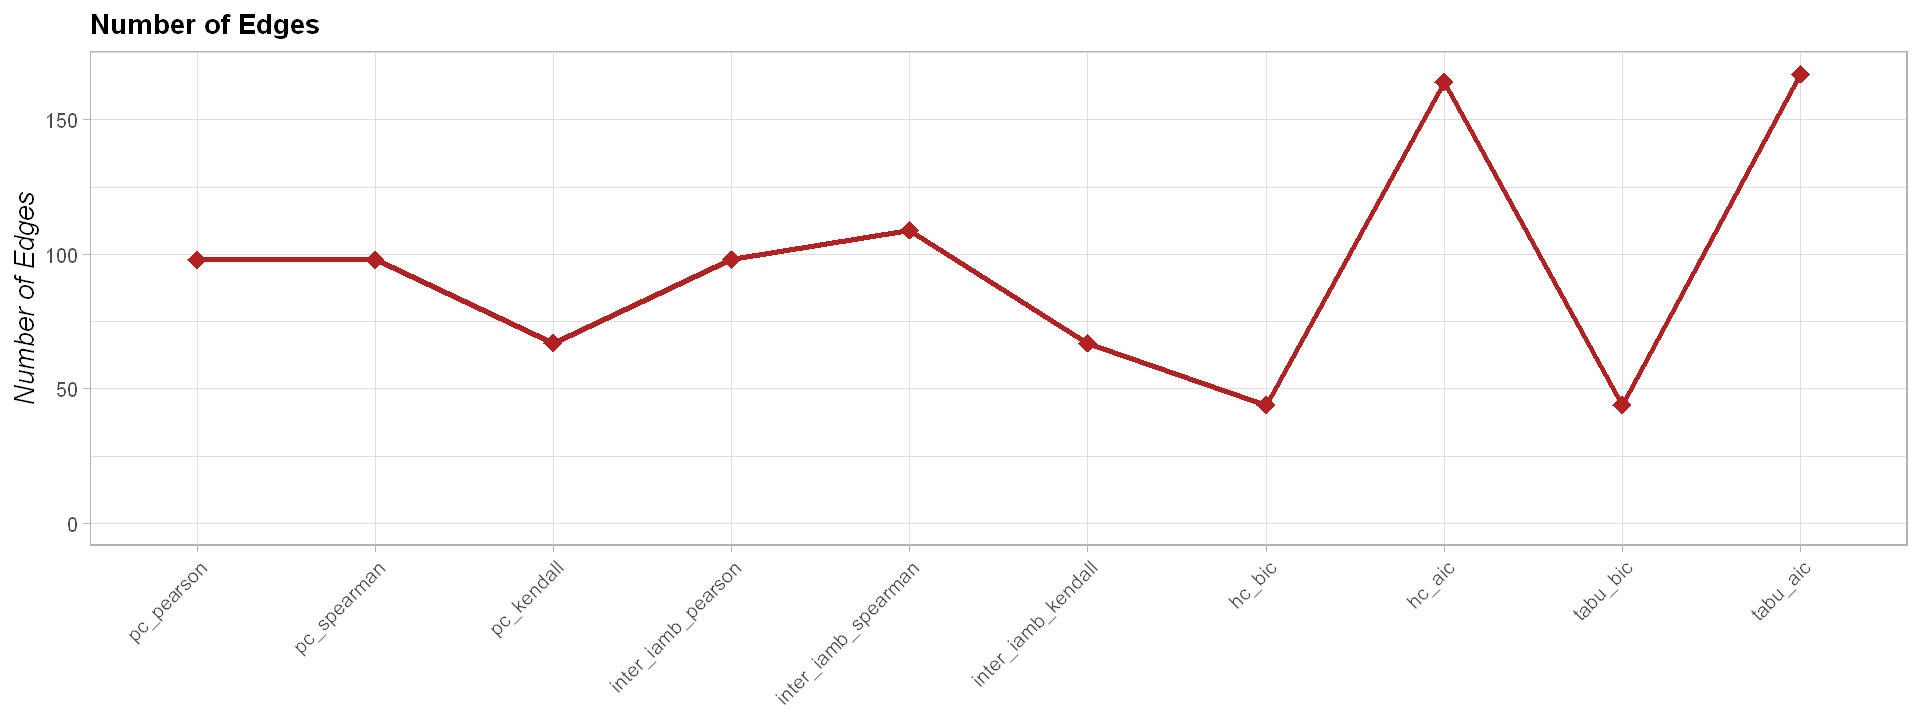

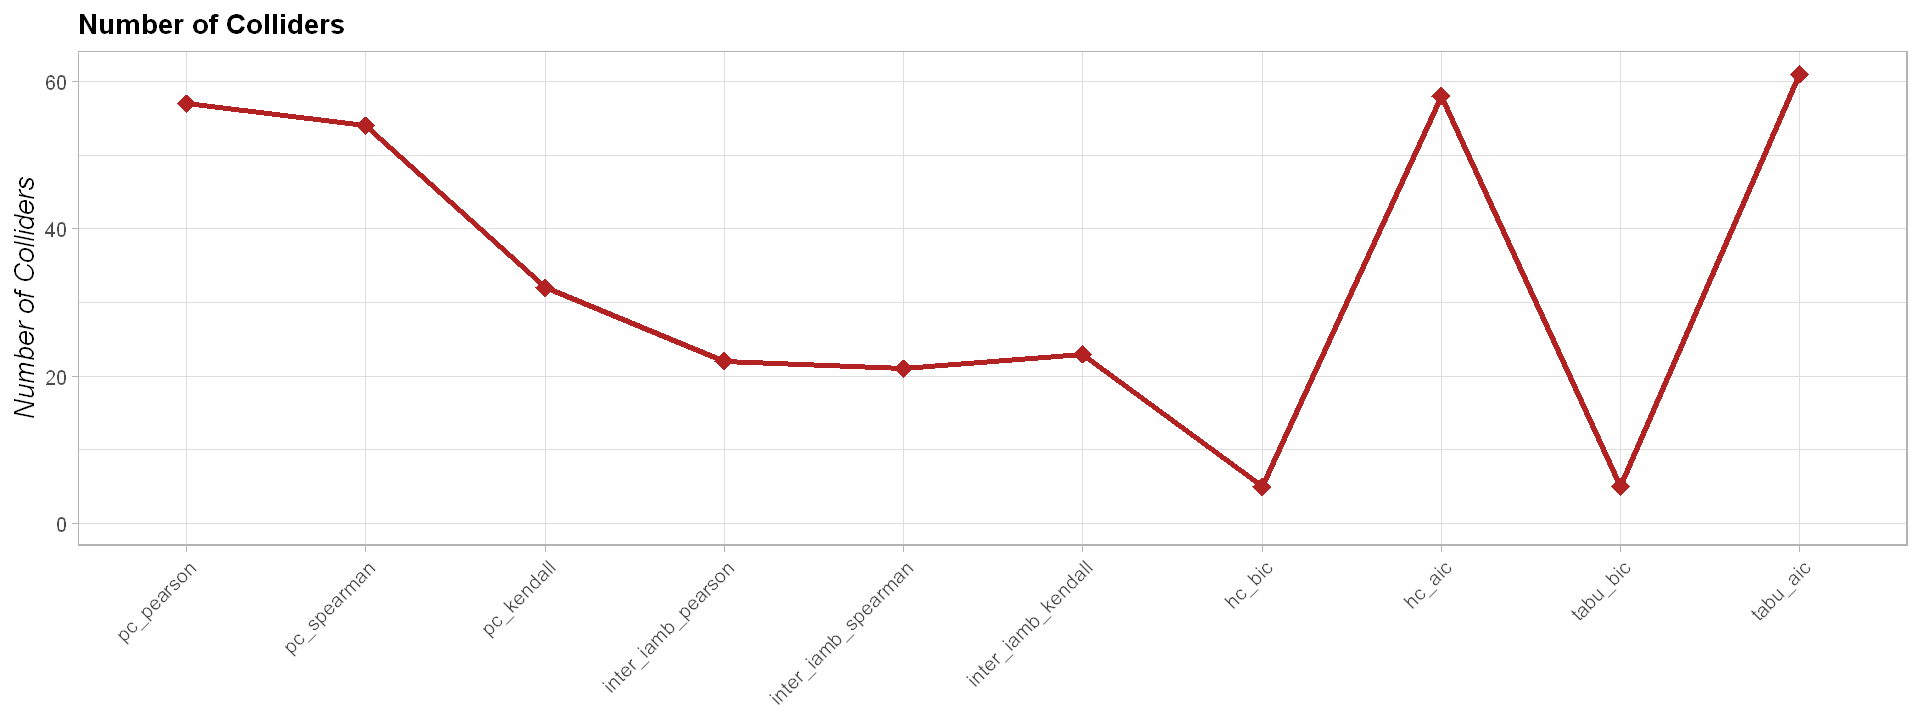

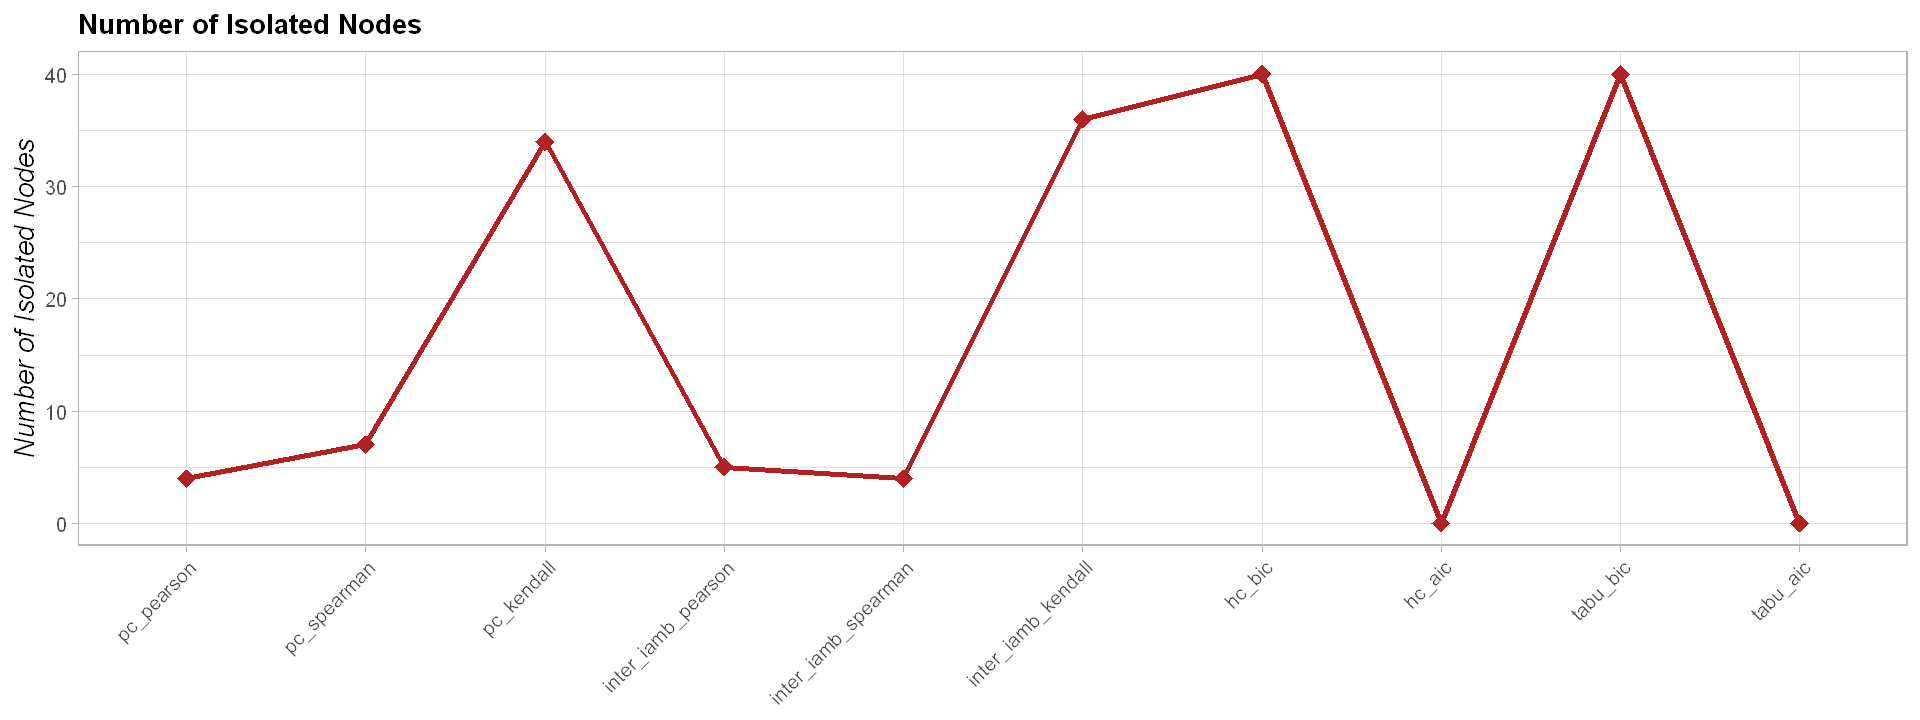

In [42]:
options(repr.plot.width = 16, repr.plot.height = 6)
plot_metric <- function(data, x, y, title) {
  ggplot(data, aes(x = .data[[x]], y = .data[[y]])) +
    geom_line(group = 1, linewidth = 1.5, color = "firebrick") +
    geom_point(shape = 18, size = 5, color = "firebrick") +
    labs(
      title = title,
      x = NULL,
      y = title
    ) +
    theme_light(base_size = 15) +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      plot.title = element_text(size = 16, face = "bold"),
      axis.title.y = element_text(size = 16, face = "italic")
    ) +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 15)) +
    expand_limits(y = 0)
}
plot_metric(df_var, 'dag2name', 'n_edges', 'Number of Edges')  
plot_metric(df_var, 'dag2name', 'n_colliders', 'Number of Colliders')
plot_metric(df_var, 'dag2name', 'n_isolated_nodes', 'Number of Isolated Nodes')  

## Plot comparative metrics

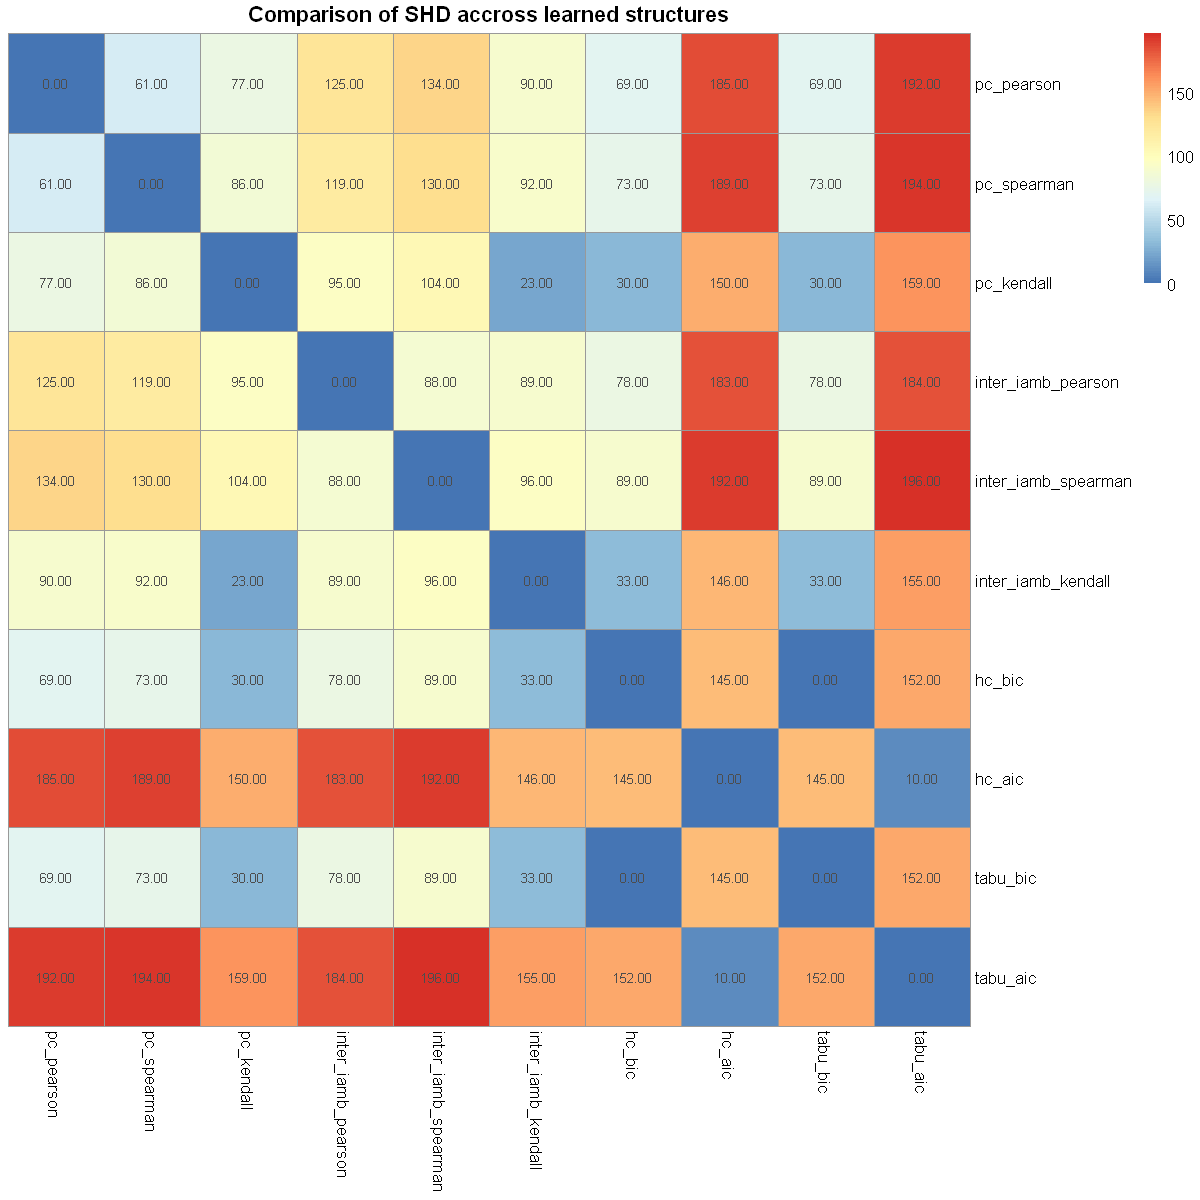

In [44]:
df_dags <- results %>%
  filter(Variable == "All") %>%
  select(dag1name, dag2name, shd)
df_wide <- df_dags %>%
  pivot_wider(names_from = dag1name, values_from = shd) %>%
  mutate_all(~replace_na(., 0))

df_wide <- df_wide %>%
  arrange(factor(dag2name, levels = order_list))

df_wide <- df_wide %>%
  select(dag2name, all_of(order_list))


df_matrix <- as.matrix(df_wide[, -1])


rownames(df_matrix) <- df_wide$dag2name


options(repr.plot.width = 10, repr.plot.height = 10)
pheatmap(df_matrix,
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         display_numbers = TRUE,
         number_format = "%.2f",
         main = paste("Comparison of SHD accross learned structures"))